# COSC 3337 - Group Project
### Spencer Ennadi-Johnson : 1597600 
### Heer Loungani : 2173441 
### Vitor Santos : 2234870 

# Data Preprocessing

### Dataset Stats -> dataset_quality_report.csv :
- invalid records with empty attributes, duplicate records, or incorrect hyphenations

In [3]:
import pandas as pd
import re
from collections import defaultdict
from io import StringIO

# --------------------------------------------
# Rules
# --------------------------------------------
HYPH_REGEX = r"[A-Za-z]-\s+(?!and\b|a\b|und\b|or\b)[a-z]"
hyphenation_re = re.compile(HYPH_REGEX)


# --------------------------------------------
# Chunked reader for JSONL
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[{}]".format(",".join(batch))
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[{}]".format(",".join(batch))
            yield pd.read_json(StringIO(json_text))


# --------------------------------------------
# Fast profiling + EXAMPLES collection (NEW)
# --------------------------------------------
def profile_chunk(df, seen_ids, seen_rows_hashes, examples):
    stats = defaultdict(int)

    # ----------------------------------------
    # EMPTY FIELDS
    # ----------------------------------------
    if "authors" in df:
        mask = df["authors"].map(lambda x: len(x) == 0 if isinstance(x, list) else False)
        stats["empty_authors"] += mask.sum()

    if "references" in df:
        mask = df["references"].map(lambda x: len(x) == 0 if isinstance(x, list) else False)
        stats["empty_references"] += mask.sum()

    # string columns
    for col in ["title", "venue", "abstract"]:
        if col in df:
            mask = (
                df[col].isna() |
                df[col].eq("") |
                df[col].eq("NaN")
            )
            stats[f"empty_{col}"] += mask.sum()

    # numeric fields
    for col in ["year", "n_citation"]:
        if col in df:
            mask = df[col].isna()
            stats[f"empty_{col}"] += mask.sum()

    # ----------------------------------------
    # HYPHENATION
    # ----------------------------------------
    for col in ["title", "venue", "abstract"]:
        if col in df:
            mask = df[col].astype(str).str.contains(HYPH_REGEX, regex=True, na=False)
            stats[f"hyph_{col}"] += mask.sum()

            for v in df.loc[mask, col].head(5 - len(examples[f"hyph_{col}"])):
                if len(examples[f"hyph_{col}"]) < 5:
                    examples[f"hyph_{col}"].append(v)

    # ----------------------------------------
    # DUPLICATE IDS (GLOBAL)
    # ----------------------------------------
    if "id" in df:
        for val in df["id"].astype(str):
            if val in seen_ids:
                stats["duplicate_ids"] += 1
            else:
                seen_ids.add(val)

    # ----------------------------------------
    # DUPLICATE FULL ROWS (GLOBAL)
    # ----------------------------------------
    df_for_dupes = df.copy()
    for col in df_for_dupes.columns:
        if df_for_dupes[col].apply(lambda x: isinstance(x, list)).any():
            df_for_dupes[col] = df_for_dupes[col].astype(str)

    row_hashes = df_for_dupes.astype(str).agg('|'.join, axis=1)

    for h in row_hashes:
        if h in seen_rows_hashes:
            stats["duplicate_rows"] += 1
        else:
            seen_rows_hashes.add(h)

    stats["rows"] += len(df)
    return stats


# --------------------------------------------
# Profile entire file
# --------------------------------------------
def profile_file(path, examples):
    totals = defaultdict(int)
    seen_ids = set()
    seen_rows_hashes = set()

    for chunk in read_jsonl_chunks(path):
        chunk_stats = profile_chunk(chunk, seen_ids, seen_rows_hashes, examples)
        for k, v in chunk_stats.items():
            totals[k] += v

    return totals


# --------------------------------------------
# Summary for multiple files
# --------------------------------------------
def profile_files(jsonl_files):
    report_rows = []

    # storage for examples across ALL files
    examples = defaultdict(list)

    for file in jsonl_files:
        print(f"Processing {file} ...")

        totals = profile_file(file, examples)

        row = {
            "file": file,
            "rows_total": totals["rows"],
            "duplicate_rows": totals["duplicate_rows"],
            "duplicate_ids": totals["duplicate_ids"],
        }

        for col in ["authors", "references", "title", "venue", "abstract", "year", "n_citation"]:
            row[f"empty_{col}"] = totals.get(f"empty_{col}", 0)
            row[f"hyphen_{col}"] = totals.get(f"hyph_{col}", 0)

        report_rows.append(row)

    return pd.DataFrame(report_rows), examples


# --------------------------------------------
# Run
# --------------------------------------------
files = [
    "dblp-ref-0.json",
    "dblp-ref-1.json",
    "dblp-ref-2.json",
    "dblp-ref-3.json"
]

summary_report, examples = profile_files(files)
summary_report.to_csv("dataset_quality_report.csv", index=False)
print(summary_report)
print("\nEXAMPLES OF INVALID DATA:")
for k, v in examples.items():
    print(f"\n{k}:")
    for ex in v:
        print("  -", ex)


Processing dblp-ref-0.json ...
Processing dblp-ref-1.json ...
Processing dblp-ref-2.json ...
Processing dblp-ref-3.json ...
              file  rows_total  duplicate_rows  duplicate_ids  empty_authors  \
0  dblp-ref-0.json     1000000               0              0              0   
1  dblp-ref-1.json     1000000               0              0              0   
2  dblp-ref-2.json     1000000               0              0              0   
3  dblp-ref-3.json       79007               0              0              0   

   hyphen_authors  empty_references  hyphen_references  empty_title  \
0               0             70708                  0            0   
1               0             82388                  0            0   
2               0             56395                  0            0   
3               0              2528                  0            0   

   hyphen_title  empty_venue  hyphen_venue  empty_abstract  hyphen_abstract  \
0           298       210500            

### Clean Dataset -> dblp-validated-00-17.json :
- remove duplicates, records with empty required features
- correct hyphenation
- apply year filter (2000 through 2017)

### Provide Stats on Intermediate Dataset

Processing dblp-ref-0.json ...
Processing dblp-ref-1.json ...
Processing dblp-ref-2.json ...
Processing dblp-ref-3.json ...

Done. Cleaned dataset written to:
dblp-validated-00-17.json

Total records: 1765554
Unique venues: 4168


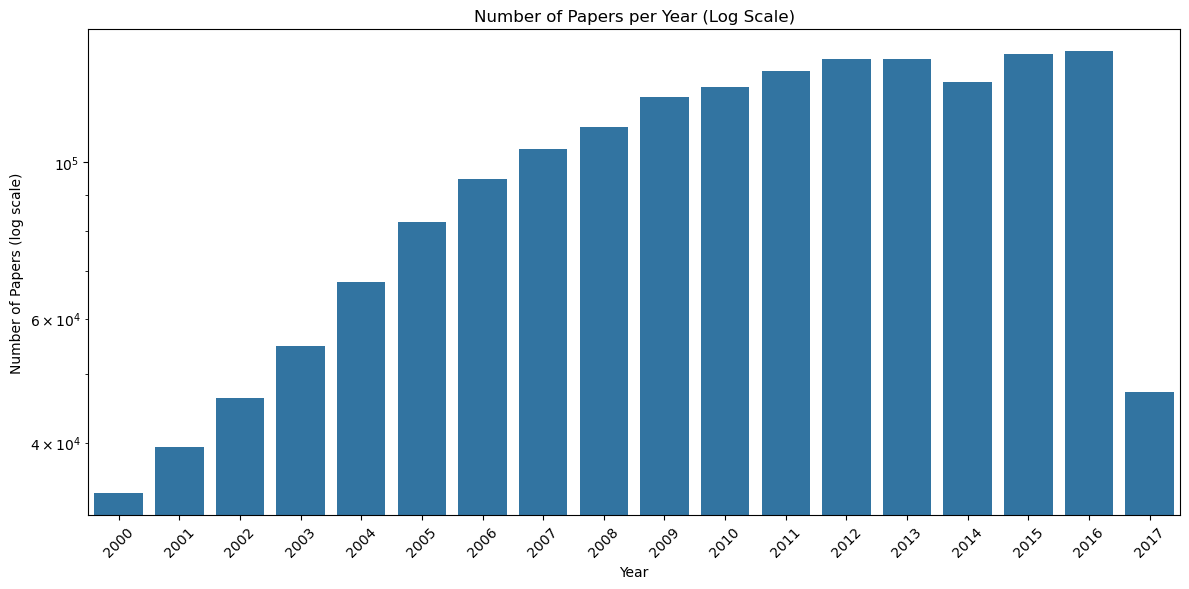

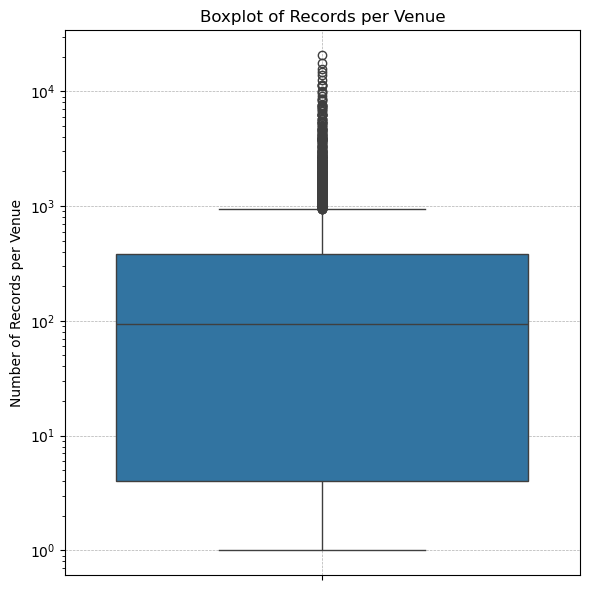

Venue stats:
Q1 = 4.0, Q3 = 380.25, IQR = 376.25
Upper fence = 944.625, Upper whisker = 944


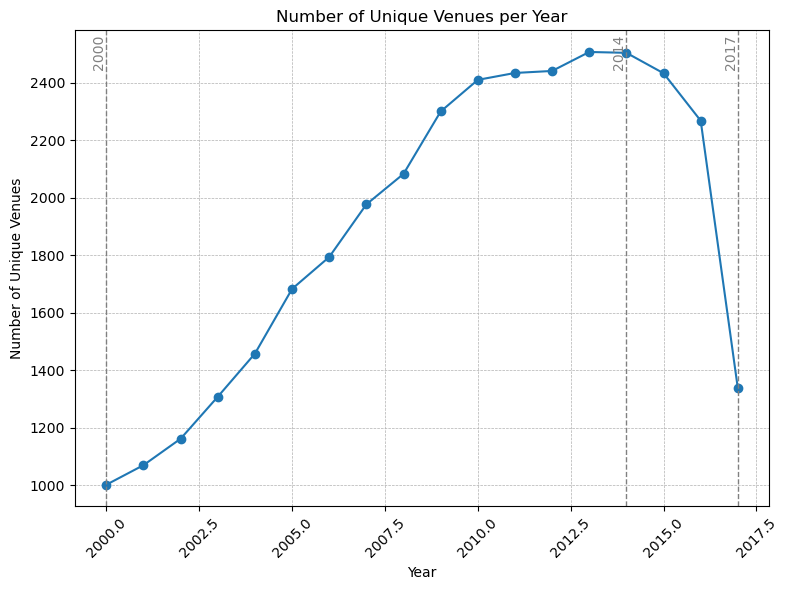

In [4]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from io import StringIO
from collections import defaultdict

# Required fields
REQUIRED_LIST_FIELDS = ["authors", "references"]
REQUIRED_STR_FIELDS = ["title", "venue", "abstract"]  # venue now also gets hyphen fixes

# Hyphenation detection regex
HYPH_REGEX = r"[A-Za-z]-\s+(?!and\b|a\b|und\b|or\b)[a-z]"
HYPH_FIX_REGEX = re.compile(r"([A-Za-z])- (\b(?!and\b|a\b|und\b|or\b)[a-z])")  # lowercase follow only

# --------------------------------------------
# Chunked JSONL reader
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))
                batch = []
        if batch:
            yield pd.read_json(StringIO("[" + ",".join(batch) + "]"))

# --------------------------------------------
# Fix hyphenation
# --------------------------------------------
def fix_hyphenation_series(series):
    return series.where(
        series.isna(),
        series.astype(str).str.replace(HYPH_FIX_REGEX, r"\1\2", regex=True)
    )

# --------------------------------------------
# Clean a single chunk + compute stats
# --------------------------------------------
def clean_chunk(df, seen_ids, stats):
    df = df.copy()

    # Filter year range (2000-2017)
    if "year" in df:
        df = df[pd.to_numeric(df["year"], errors="coerce").between(2000, 2017)]

    # Fix hyphenation
    for col in ["title", "abstract", "venue"]:
        if col in df:
            df[col] = fix_hyphenation_series(df[col])

    # Remove empty list fields
    for col in REQUIRED_LIST_FIELDS:
        if col in df:
            df = df[df[col].map(lambda x: isinstance(x, list) and len(x) > 0)]

    # Remove empty string fields
    for col in REQUIRED_STR_FIELDS:
        if col in df:
            df = df[~df[col].isna()]
            df = df[~df[col].eq("") & ~df[col].eq("NaN")]

    # Deduplicate IDs
    if "id" in df:
        id_series = df["id"].astype(str)
        dup_mask = id_series.isin(seen_ids)
        if dup_mask.any():
            df = df[~dup_mask]
        seen_ids.update(df["id"].astype(str).tolist())

    # --------------------------------------------
    # Update stats during cleaning
    # --------------------------------------------
    stats["total_records"] += len(df)

    if "venue" in df:
        venues = df["venue"].dropna()
        stats["unique_venues"].update(venues.unique())
        for v in venues:
            stats["venue_counts"][v] += 1

    if "year" in df:
        years = df["year"].dropna()
        stats["unique_years"].update(years.unique())
        for y in years:
            stats["year_counts"][y] += 1

    # Venues per year
    if "year" in df and "venue" in df:
        for y, v in zip(df["year"], df["venue"]):
            if pd.notna(y) and pd.notna(v):
                stats["venues_per_year"][y].add(v)

    return df

# --------------------------------------------
# Clean multiple files into ONE file and collect stats
# --------------------------------------------
def clean_files_to_one(input_files, output_file, chunksize=100_000):
    seen_ids = set()
    stats = {
        "total_records": 0,
        "unique_venues": set(),
        "unique_years": set(),
        "year_counts": defaultdict(int),
        "venue_counts": defaultdict(int),
        "venues_per_year": defaultdict(set)
    }

    with open(output_file, "w", encoding="utf-8") as fout:
        for input_path in input_files:
            print(f"Processing {input_path} ...")
            for chunk in read_jsonl_chunks(input_path, chunksize=chunksize):
                cleaned_chunk = clean_chunk(chunk, seen_ids, stats)
                if len(cleaned_chunk) == 0:
                    continue

                for record in cleaned_chunk.to_dict(orient="records"):
                    fout.write(json.dumps(record) + "\n")

    print(f"\nDone. Cleaned dataset written to:\n{output_file}")

    # Convert venue sets to counts per year
    stats["venues_count_per_year"] = {y: len(vs) for y, vs in stats["venues_per_year"].items()}
    return stats

# --------------------------------------------
# Example run
# --------------------------------------------
if __name__ == "__main__":
    input_files = [
        "dblp-ref-0.json",
        "dblp-ref-1.json",
        "dblp-ref-2.json",
        "dblp-ref-3.json"
    ]
    output_file = "dblp-validated-00-17.json"

    stats = clean_files_to_one(input_files, output_file)

    # Convert stats sets to sorted lists for printing/plotting
    stats["unique_venues"] = sorted(stats["unique_venues"])
    stats["unique_years"] = sorted(stats["unique_years"])
    
    print(f"\nTotal records: {stats['total_records']}")
    print(f"Unique venues: {len(stats['unique_venues'])}")
    # -------------------------------
    # Records per year (log scale)
    # -------------------------------
    plt.figure(figsize=(12, 6))
    sns.barplot(x=list(stats['year_counts'].keys()), y=list(stats['year_counts'].values()))
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Number of Papers (log scale)")
    plt.title("Number of Papers per Year (Log Scale)")
    plt.tight_layout()
    plt.show()

    # -------------------------------
    # Records per venue (boxplot)
    # -------------------------------
    venue_counts_list = list(stats['venue_counts'].values())
    plt.figure(figsize=(6, 6))
    sns.boxplot(y=venue_counts_list)
    plt.yscale('log')
    plt.ylabel("Number of Records per Venue")
    plt.title("Boxplot of Records per Venue")
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # Compute Tukey's upper whisker
    vc = np.array(venue_counts_list)
    Q1 = np.percentile(vc, 25)
    Q3 = np.percentile(vc, 75)
    IQR = Q3 - Q1
    upper_fence = Q3 + 1.5 * IQR
    upper_whisker = vc[vc <= upper_fence].max()

    print("Venue stats:")
    print(f"Q1 = {Q1}, Q3 = {Q3}, IQR = {IQR}")
    print(f"Upper fence = {upper_fence}, Upper whisker = {upper_whisker}")

    # -------------------------------
    # Venues per year (line plot + vertical markers)
    # -------------------------------
    years_sorted = sorted(stats['venues_count_per_year'].keys())
    values_sorted = [stats['venues_count_per_year'][y] for y in years_sorted]

    plt.figure(figsize=(8, 6))
    plt.plot(years_sorted, values_sorted, marker='o', linestyle='-')

    milestones = [2000, 2014, 2017]
    for yr in milestones:
        plt.axvline(x=yr, color='gray', linestyle='--', linewidth=1)
        plt.text(yr, max(values_sorted), str(yr),
                 rotation=90, va='center', ha='right', color='gray')

    plt.xlabel("Year")
    plt.ylabel("Number of Unique Venues")
    plt.title("Number of Unique Venues per Year")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


### Remove venues under 1k and separate by (2000-2014) and (2015-2017)
- dblp-venues-over-1k-00-14.json
- dblp-venues-over-1k-15-17.json

In [5]:
import json
import pandas as pd
from collections import defaultdict
from io import StringIO


# --------------------------------------------
# Chunked JSONL reader
# --------------------------------------------
def read_jsonl_chunks(path, chunksize=100_000):
    batch = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            batch.append(line.rstrip("\n"))
            if (i + 1) % chunksize == 0:
                json_text = "[" + ",".join(batch) + "]"
                yield pd.read_json(StringIO(json_text))
                batch = []
        if batch:
            json_text = "[" + ",".join(batch) + "]"
            yield pd.read_json(StringIO(json_text))


# --------------------------------------------------------------------
# PASS 1 — Count venue frequencies
# --------------------------------------------------------------------
def compute_venue_counts(path, chunksize=100_000):
    venue_counts = defaultdict(int)

    print(f"Counting venues in {path} ...")

    for chunk in read_jsonl_chunks(path, chunksize=chunksize):
        if "venue" in chunk:
            for v in chunk["venue"].dropna():
                venue_counts[v] += 1

    print("Done counting venue frequencies.")
    return venue_counts


# --------------------------------------------------------------------
# PASS 2 — Filter venues >= threshold AND split by year ranges
# --------------------------------------------------------------------
def filter_and_split_by_year(
    path, 
    venue_counts, 
    min_count=1000, 
    chunksize=100_000,
    out_2000_2014="dblp-venues-over-1k-00-14.json",
    out_2015_2017="dblp-venues-over-1k-15-17.json"
):

    # Open both output files
    f1 = open(out_2000_2014, "w", encoding="utf-8")
    f2 = open(out_2015_2017, "w", encoding="utf-8")

    print(f"Filtering papers in {path} and splitting by year...")

    for chunk in read_jsonl_chunks(path, chunksize=chunksize):

        if "venue" not in chunk or "year" not in chunk:
            continue

        # Filter by venue strength
        mask = chunk["venue"].map(lambda v: venue_counts.get(v, 0) >= min_count)
        filtered = chunk[mask]

        # Write to the correct file based on year
        for _, row in filtered.iterrows():
            y = row["year"]
            if pd.isna(y):
                continue

            rec = json.dumps(row.to_dict())

            if 2000 <= y <= 2014:
                f1.write(rec + "\n")
            elif 2015 <= y <= 2017:
                f2.write(rec + "\n")

    f1.close()
    f2.close()

    print("\nDone. Datasets written to:")
    print(f" → {out_2000_2014}")
    print(f" → {out_2015_2017}")


# --------------------------------------------------------------------
# RUN PIPELINE
# --------------------------------------------------------------------
if __name__ == "__main__":

    input_file = "dblp-validated-00-17.json"

    # Output files (you can rename freely)
    out_early = "dblp-venues-over-1k-00-14.json"
    out_late  = "dblp-venues-over-1k-15-17.json"

    # PASS 1: venue counts
    venue_counts = compute_venue_counts(input_file)

    # PASS 2: venue filter + year split output
    filter_and_split_by_year(
        input_file,
        venue_counts,
        min_count=1000,
        out_2000_2014=out_early,
        out_2015_2017=out_late
    )


Counting venues in dblp-validated-00-17.json ...
Done counting venue frequencies.
Filtering papers in dblp-validated-00-17.json and splitting by year...

Done. Datasets written to:
 → dblp-venues-over-1k-00-14.json
 → dblp-venues-over-1k-15-17.json


# Feature Engineering and Temporal Classification
This section constructs time-aware venue and author features and trains a temporal model
to predict high-impact papers using data from 2000–2014, then evaluates on 2015–2017.

In [6]:
import pandas as pd

# Load training and test sets
train_path = "dblp-venues-over-1k-00-14.json"
test_path = "dblp-venues-over-1k-15-17.json"

df_train = pd.read_json(train_path, lines=True)
df_test = pd.read_json(test_path, lines=True)

df_train["split"] = "train"
df_test["split"]  = "test"

Basic Numeric Feature Engineering to compute simple document and metadata features

In [7]:
for df in [df_train, df_test]:
    df["abstract_length_words"] = df["abstract"].str.split().str.len()
    df["num_authors"] = df["authors"].apply(len)
    df["num_references"] = df["references"].apply(len)

Merge Train and Test datasets to compute cumulative venue and author statistics without leakage

In [8]:
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all = df_all.sort_values("year")

Compute Venue Prestige (Cumulative Up to Previous Year)

In [9]:
venue_year = (
    df_all.groupby(["venue","year"])
    .agg(
        venue_year_n_papers=("id","count"),
        venue_year_total_citations=("n_citation","sum")
    ).reset_index()
)

venue_year = venue_year.sort_values(["venue","year"])
venue_year["venue_cum_papers"]     = venue_year.groupby("venue")["venue_year_n_papers"].cumsum()
venue_year["venue_cum_citations"]  = venue_year.groupby("venue")["venue_year_total_citations"].cumsum()
venue_year["venue_cum_mean"]       = venue_year["venue_cum_citations"] / venue_year["venue_cum_papers"]

venue_year["venue_cum_papers_past"]    = venue_year.groupby("venue")["venue_cum_papers"].shift(1)
venue_year["venue_cum_citations_past"] = venue_year.groupby("venue")["venue_cum_citations"].shift(1)
venue_year["venue_cum_mean_past"]      = venue_year.groupby("venue")["venue_cum_mean"].shift(1)

df_all = df_all.merge(
    venue_year[[
        "venue","year",
        "venue_cum_papers_past","venue_cum_citations_past","venue_cum_mean_past"
    ]],
    on=["venue","year"],
    how="left"
)


Compute Author Reputation (Cumulative Up to Previous Year)

In [10]:
authors_long = (
    df_all[["id","year","n_citation","authors"]]
    .explode("authors")
    .rename(columns={"authors":"author"})
)

author_year = (
    authors_long.groupby(["author","year"])
    .agg(
        author_year_n_papers=("id","count"),
        author_year_total_citations=("n_citation","sum")
    ).reset_index()
)

author_year = author_year.sort_values(["author","year"])
author_year["author_cum_papers"]    = author_year.groupby("author")["author_year_n_papers"].cumsum()
author_year["author_cum_citations"] = author_year.groupby("author")["author_year_total_citations"].cumsum()
author_year["author_cum_mean"]      = author_year["author_cum_citations"] / author_year["author_cum_papers"]

author_year["author_cum_papers_past"]    = author_year.groupby("author")["author_cum_papers"].shift(1)
author_year["author_cum_citations_past"] = author_year.groupby("author")["author_cum_citations"].shift(1)
author_year["author_cum_mean_past"]      = author_year.groupby("author")["author_cum_mean"].shift(1)

authors_long = authors_long.merge(
    author_year[[
        "author","year",
        "author_cum_papers_past","author_cum_citations_past","author_cum_mean_past"
    ]],
    on=["author","year"],
    how="left"
)

author_rep = (
    authors_long.groupby("id")
    .agg(
        author_past_papers_sum=("author_cum_papers_past","sum"),
        author_past_citations_sum=("author_cum_citations_past","sum"),
        author_past_mean_citations_mean=("author_cum_mean_past","mean"),
        author_past_mean_citations_max=("author_cum_mean_past","max")
    )
    .reset_index()
)

df_all = df_all.merge(author_rep, on="id", how="left")
df_all = df_all.loc[:, ~df_all.columns.duplicated()]


Restore Clean Train/Test Splits and recover temporal splits after time-dependent feature engineering

In [11]:
df_train = df_all[df_all["split"]=="train"].copy()
df_test  = df_all[df_all["split"]=="test"].copy()

Recompute High-Impact Labels (Top 10% Citations Per Year), labels are recomputed AFTER merging to avoid losing 'high_impact'

In [12]:
# training labels
train_thresh = df_train.groupby("year")["n_citation"].quantile(0.9)
df_train = df_train.merge(train_thresh.rename("year_threshold"), on="year", how="left")
df_train["high_impact"] = (df_train["n_citation"] >= df_train["year_threshold"]).astype(int)

# testing labels
test_thresh = df_test.groupby("year")["n_citation"].quantile(0.9)
df_test = df_test.merge(test_thresh.rename("year_threshold"), on="year", how="left")
df_test["high_impact"] = (df_test["n_citation"] >= df_test["year_threshold"]).astype(int)

TF-IDF Text Features to convert paper abstracts into TF-IDF vectors

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
X_text_train = tfidf.fit_transform(df_train["abstract"])
X_text_test  = tfidf.transform(df_test["abstract"])

Numeric Feature Matrix to scale features for smooth optimization

In [14]:
num_features = [
    "abstract_length_words","num_authors","num_references",
    "venue_cum_papers_past","venue_cum_citations_past","venue_cum_mean_past",
    "author_past_papers_sum","author_past_citations_sum",
    "author_past_mean_citations_mean","author_past_mean_citations_max"
]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_num_train = scaler.fit_transform(df_train[num_features].fillna(0))
X_num_test  = scaler.transform(df_test[num_features].fillna(0))


Combine text and numeric features to construct full model input matrices

In [15]:
from scipy.sparse import hstack

X_train = hstack([X_text_train, X_num_train])
X_test  = hstack([X_text_test,  X_num_test])

y_train = df_train["high_impact"].values
y_test  = df_test["high_impact"].values


Train Logistic Regression Model to train validation split and initial performance check


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

log_reg = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1)
log_reg.fit(X_tr, y_tr)

print(classification_report(y_val, log_reg.predict(X_val), digits=3))


              precision    recall  f1-score   support

           0      0.899     0.709     0.793    145687
           1      0.340     0.652     0.447     33429

    accuracy                          0.699    179116
   macro avg      0.619     0.681     0.620    179116
weighted avg      0.795     0.699     0.728    179116



Evaluate on Future Papers (2015-2017), temporal generalization test on unseen future years

In [17]:
y_test_pred = log_reg.predict(X_test)
y_test_prob = log_reg.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_test_pred, digits=3))

              precision    recall  f1-score   support

           0      0.885     0.373     0.525    186038
           1      0.188     0.750     0.301     35970

    accuracy                          0.434    222008
   macro avg      0.537     0.562     0.413    222008
weighted avg      0.772     0.434     0.489    222008



Confusion matrix for visual inspection of prediction distribution

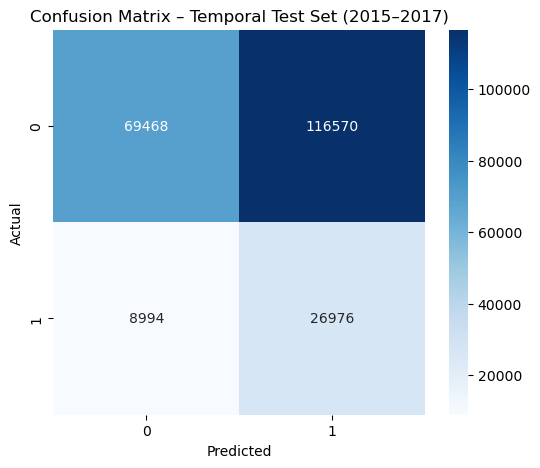

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix – Temporal Test Set (2015–2017)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC Curve showA model discriminatiVE ability.

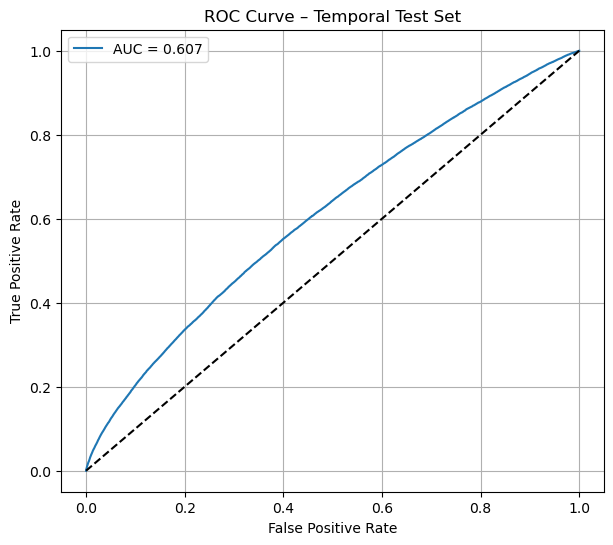

In [19]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Temporal Test Set")
plt.legend()
plt.grid(True)
plt.show()


Precision–Recall Curve is useful due to class imbalance.

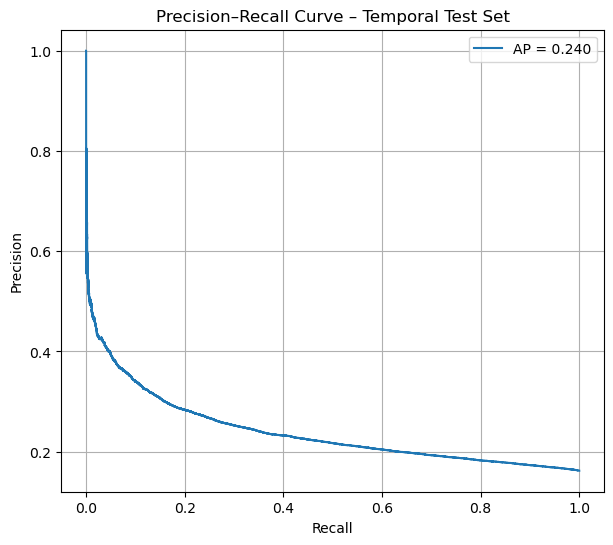

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
ap = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Temporal Test Set")
plt.legend()
plt.grid(True)
plt.show()


Residual Distribution (For Anomaly Detection)


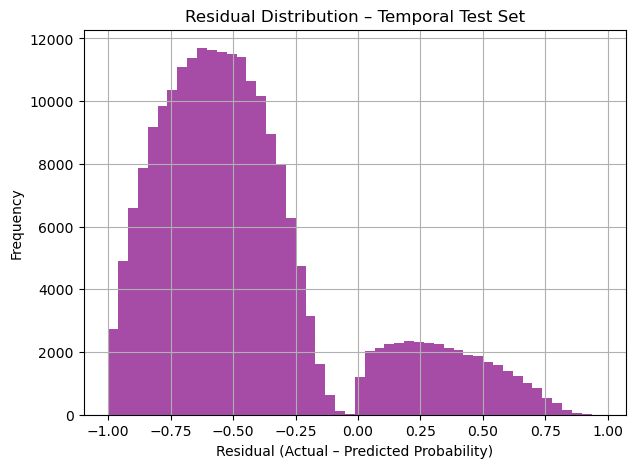

In [21]:
df_test["residual"] = df_test["high_impact"] - y_test_prob

plt.figure(figsize=(7,5))
plt.hist(df_test["residual"], bins=50, color="purple", alpha=0.7)
plt.xlabel("Residual (Actual – Predicted Probability)")
plt.ylabel("Frequency")
plt.title("Residual Distribution – Temporal Test Set")
plt.grid(True)
plt.show()


Save Model Prediction

In [27]:
df_test["predicted_prob"] = y_test_prob
df_test["predicted_label"] = y_test_pred

df_test.to_parquet("temporal_predictions_2015_2017.parquet")
df_test.head()

,abstract,authors,n_citation,references,title,venue,year,id,split,abstract_length_words,...,venue_cum_mean_past,author_past_papers_sum,author_past_citations_sum,author_past_mean_citations_mean,author_past_mean_citations_max,year_threshold,high_impact,residual,predicted_prob,predicted_label
0,This paper presents the first published fully-...,"[Christian Venerus, Ian Galton]",11,"[01ac5fce-6a7a-483c-b76a-8a5b49b1572b, 0dd0d0d...",A TDC-Free Mostly-Digital FDC-PLL Frequency Sy...,IEEE Journal of Solid-state Circuits,2015,e8595565-6be4-4047-bb31-4f22f77bd35e,test,216,...,46.505576,21.0,596.0,18.815789,30.631579,50.0,0,-0.712177,0.712177,1
1,We present a novel approach to separating pitc...,[Miroslav Zivanovic],0,"[00b47001-3db4-4101-8080-eaf0adfc5dac, 03e2ca5...",Harmonic bandwidth companding for separation o...,"IEEE Transactions on Audio, Speech, and Langua...",2015,e85e3089-dfd2-449b-b734-5e5e2dd5b68d,test,140,...,61.489227,7.0,213.0,30.428571,30.428571,50.0,0,-0.623665,0.623665,1
2,Intermittent high intensity ultrasound pulses ...,"[Yiying I. Zhu, Douglas L. Miller, Chunyan Dou...",50,"[2df9bdf8-4333-4f02-a81f-c6420da1c216, f5ba7b8...",Characterization of Macrolesions Induced by My...,IEEE Transactions on Biomedical Engineering,2015,e85cda7e-052f-48f7-9502-2fe78a4b3e14,test,249,...,61.704803,1.0,3.0,3.000000,3.000000,50.0,1,0.573719,0.426281,0
3,This paper presents a spectrum monitoring algo...,"[Abdelmohsen Ali, Walaa Hamouda]",19,"[0fd91b1b-8d09-4be9-b372-cdbf17c21037, 20fbecb...",Spectrum Monitoring Using Energy Ratio Algorit...,IEEE Transactions on Wireless Communications,2015,e8618c39-6ccf-4db8-bdf4-557138b11ccf,test,170,...,66.770465,86.0,2290.0,26.627907,26.627907,50.0,0,-0.713434,0.713434,1
4,We investigate a parameter plane of a set of t...,"[Rodrigo A. da Silva, Paulo C. Rech]",1,"[000721ca-1d0a-428a-82fb-a491cc551e38, 18755d2...",Spiral periodic structures in a parameter plan...,Applied Mathematics and Computation,2015,e85a6433-2417-4287-a5b7-df4af3053ebd,test,76,...,28.868451,12.0,114.0,9.500000,9.500000,50.0,0,-0.427949,0.427949,0


# Anomaly Detection and Topic Drift

Save the TF-IDF, scalar, model, and engineered datasets from the last part to reuse in this task. 

In [28]:
print("Saving TF-IDF, scaler, model, and engineered datasets...")

import joblib

# Save vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save numeric scaler
joblib.dump(scaler, "numeric_scaler.pkl")

# Save trained logistic regression model
joblib.dump(log_reg, "temporal_logistic_regression.pkl")

# Save full feature matrices
joblib.dump(X_train, "X_train_sparse.pkl")
joblib.dump(X_test, "X_test_sparse.pkl")

# Save engineered dataframes
df_train.to_parquet("df_train_engineered.parquet")
df_test.to_parquet("df_test_engineered.parquet")   # includes predictions + residuals
df_all.to_parquet("df_all_engineered.parquet")

print("All temporal modeling artifacts saved successfully.")


Saving TF-IDF, scaler, model, and engineered datasets...
All temporal modeling artifacts saved successfully.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse, vstack
from scipy.stats import chi2_contingency
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.preprocessing import StandardScaler


In [2]:
sns.set(style="whitegrid")
RND = 42
np.random.seed(RND)

Load dataframes and artifacts

In [4]:
TFIDF_PATH = "tfidf_vectorizer.pkl"
SCALER_PATH = "numeric_scaler.pkl"
MODEL_PATH = "temporal_logistic_regression.pkl"
X_TRAIN_PATH = "X_train_sparse.pkl"
X_TEST_PATH  = "X_test_sparse.pkl"
DF_TRAIN_PATH = "df_train_engineered.parquet"
DF_TEST_PATH  = "df_test_engineered.parquet"
DF_ALL_PATH   = "df_all_engineered.parquet"
PRED_PATH     = "temporal_predictions_2015_2017.parquet"

# Load dataframes and artifacts 
assert os.path.exists(DF_TEST_PATH), f"Missing {DF_TEST_PATH} — run FE/classification and save df_test_engineered.parquet"
assert os.path.exists(DF_ALL_PATH), f"Missing {DF_ALL_PATH} — run FE/classification and save df_all_engineered.parquet"
assert os.path.exists(TFIDF_PATH), f"Missing {TFIDF_PATH}"
assert os.path.exists(SCALER_PATH), f"Missing {SCALER_PATH}"

df_test = pd.read_parquet(DF_TEST_PATH)
df_all  = pd.read_parquet(DF_ALL_PATH)

tfidf = joblib.load(TFIDF_PATH)
scaler = joblib.load(SCALER_PATH)

# X_text matrices if saved
X_test = None
if os.path.exists(X_TEST_PATH):
    X_test = joblib.load(X_TEST_PATH)  # likely sparse
else:
    # fallback: compute TF-IDF for df_test abstracts
    X_test = tfidf.transform(df_test["abstract"].fillna("").astype(str))

# If df_test already contains predicted columns, use them; else load predictions file
if "predicted_prob" not in df_test.columns and os.path.exists(PRED_PATH):
    preds = pd.read_parquet(PRED_PATH)
    df_test = df_test.merge(preds[["id","predicted_prob","predicted_label"]], on="id", how="left")

print("Loaded: df_test rows =", len(df_test), ", df_all rows =", len(df_all))
print("TF-IDF vocab size:", len(tfidf.get_feature_names_out()))


Loaded: df_test rows = 222008 , df_all rows = 1117584
TF-IDF vocab size: 5000


In [5]:
# Ensure residual defined as actual (high_impact 0/1) - predicted_prob
if "high_impact" in df_test.columns and "predicted_prob" in df_test.columns:
    df_test["residual_prob"] = df_test["high_impact"].fillna(0) - df_test["predicted_prob"].fillna(0)
else:
    # if high_impact missing, try to recompute using n_citation and year thresholds (edge-case)
    if "n_citation" in df_test.columns:
        year_thresh = df_test.groupby("year")["n_citation"].quantile(0.9).rename("year_thresh")
        df_test = df_test.merge(year_thresh, on="year", how="left")
        df_test["high_impact"] = (df_test["n_citation"] >= df_test["year_thresh"]).astype(int)
        # predicted_prob might be missing — set to 0 if so (this will make residual = 1 for true high-impact)
        df_test["predicted_prob"] = df_test.get("predicted_prob", 0.0)
        df_test["residual_prob"] = df_test["high_impact"] - df_test["predicted_prob"]
    else:
        raise RuntimeError("Cannot compute residuals: missing columns 'high_impact' or 'n_citation'.")

# We'll operate on the test period set (2015-2017)
test_df = df_test.copy().reset_index(drop=True)
print("Test DF shape:", test_df.shape)


Test DF shape: (222008, 25)


Compute residual-based anomalies

In [6]:
# We define residual anomaly: papers that were observed high-impact (high_impact==1) but model predicted low (residual large positive)
# Choose quantile threshold (tunable)
RESID_QUANTILE = 0.95   # top 5% residuals (positive)
cut = test_df["residual_prob"].quantile(RESID_QUANTILE)
resid_mask = (test_df["residual_prob"] >= cut) & (test_df["high_impact"] == 1)
test_df["residual_anomaly"] = resid_mask.astype(int)
print("Residual anomalies (top {:.1%}):".format(1-RESID_QUANTILE), test_df["residual_anomaly"].sum())

# Save list
resid_anomalies = test_df[test_df["residual_anomaly"]==1].copy()
resid_anomalies.to_csv(
    "residual_anomalies.csv",
    index=False,
    escapechar="\\"
)


Residual anomalies (top 5.0%): 11101


Build combined features for unsupervised detector

In [7]:
# Use TF-IDF for the test set (X_test from earlier). If large, reduce with TruncatedSVD.
if issparse(X_test):
    n_samples, n_features = X_test.shape
else:
    n_samples, n_features = X_test.shape

# Reduce textual dims
SVD_DIM = 200
print("Performing TruncatedSVD ->", SVD_DIM, "dims")
svd = TruncatedSVD(n_components=SVD_DIM, random_state=RND)
X_text_reduced = svd.fit_transform(X_test)  # dense (n_test x SVD_DIM)

# Numeric features to include 
numeric_cols = [
    "abstract_length_words","num_authors","num_references",
    "venue_cum_papers_past","venue_cum_citations_past","venue_cum_mean_past",
    "author_past_papers_sum","author_past_citations_sum",
    "author_past_mean_citations_mean","author_past_mean_citations_max",
    "predicted_prob"
]
# Fill missing numeric cols with 0 if absent
for c in numeric_cols:
    if c not in test_df.columns:
        test_df[c] = 0

X_num = test_df[numeric_cols].fillna(0).values

try:
    num_scaler = scaler  # loaded from saved artifacts earlier
    X_num_scaled = num_scaler.transform(X_num)
except Exception:
    X_num_scaled = StandardScaler().fit_transform(X_num)

# Combine reduced text + scaled numeric (dense)
X_unsup = np.hstack([X_text_reduced, X_num_scaled])
print("Unsupervised feature matrix shape:", X_unsup.shape)


Performing TruncatedSVD -> 200 dims
Unsupervised feature matrix shape: (222008, 211)


/Users/heerloungani/miniconda3/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Isolation Forest for unsupervised anomalies

In [8]:
iso = IsolationForest(contamination=0.01, random_state=RND, n_jobs=-1)
iso.fit(X_unsup)
iso_pred = iso.predict(X_unsup)   # -1 outlier, 1 inlier
iso_score = -iso.decision_function(X_unsup)  # higher => more anomalous

test_df["iso_flag"] = (iso_pred == -1).astype(int)
test_df["iso_score"] = iso_score

print("IsolationForest anomalies:", test_df["iso_flag"].sum())
test_df[test_df["iso_flag"]==1].head()


IsolationForest anomalies: 2221


,abstract,authors,n_citation,references,title,venue,year,id,split,abstract_length_words,...,author_past_mean_citations_max,year_threshold,high_impact,residual,predicted_prob,predicted_label,residual_prob,residual_anomaly,iso_flag,iso_score
19,This paper presents the results of an empirica...,"[Michel-Alexandre Cardin, Jiang Yixin, Howard ...",2,"[0b6473f4-b98b-4568-acbf-eff9adc67b2d, 2badeae...",Training Design and Management of Flexible Eng...,systems man and cybernetics,2015,e8683ffb-332f-474f-a799-9b4473c51dfa,test,214,...,4.000000,50.0,0,-0.726674,0.726674,1,-0.726674,0,1,0.008777
138,Graph patterns are widely used to define the f...,"[Zhanghui Wang, Yuhai Zhao, Guoren Wang, Yuan ...",3,"[1586f240-c480-47e1-9833-8ae2cdea1aae, 33abc1f...",On extending extreme learning machine to non-r...,Neurocomputing,2015,e923e5a5-23d0-4a6e-8afc-d43c502e1cd0,test,217,...,55.532710,50.0,0,-0.738819,0.738819,1,-0.738819,0,1,0.019074
165,"3D depth data, especially dynamic 3D depth dat...","[Sicheng Zhao, Lujun Chen, Hongxun Yao, Yanhao...",32,"[0cc74fa1-b12c-4b4d-bd15-d68a63938c91, 0dd7934...",Strategy for dynamic 3D depth data matching to...,Neurocomputing,2015,e8b666d6-c0b1-4501-8e82-05ad62952ed7,test,228,...,33.025424,50.0,0,-0.908009,0.908009,1,-0.908009,0,1,0.010201
217,Kernel competitive learning has been successfu...,"[Jian-Sheng Wu, Wei-Shi Zheng, Jian-Huang Lai]",5,"[010793c8-fedb-49ee-88bc-1e20f8bae870, 0d37cb4...",Approximate kernel competitive learning,Neural Networks,2015,e72c907c-e6e7-46b2-aaca-8b31e8d1e966,test,268,...,87.687500,50.0,0,-0.857182,0.857182,1,-0.857182,0,1,0.002660
258,A scalable platform supporting large-scale sen...,"[Wei Wang, Suparna De, Gilbert Cassar, Klaus M...",50,"[02f5852a-1048-49af-8474-3008e35274e1, 04e4f0e...",An experimental study on geospatial indexing f...,Expert Systems With Applications,2015,e670a6d7-db7a-4b57-afa9-424ee07f53e4,test,184,...,45.027916,50.0,1,0.026146,0.973854,1,0.026146,0,1,0.015943


Merge anomalies & create final anomaly table

In [9]:
# combine residual_anomaly OR iso_flag
test_df["anomaly_flag"] = ((test_df["residual_anomaly"]==1) | (test_df["iso_flag"]==1)).astype(int)
print("Total anomalies (union):", test_df["anomaly_flag"].sum())

anomaly_table = test_df[test_df["anomaly_flag"]==1].copy()
cols_for_table = [
    "id","title","venue","year","abstract","n_citation",
    "predicted_prob","high_impact","residual_prob","iso_score"
] + numeric_cols
present_cols = [c for c in cols_for_table if c in anomaly_table.columns]
anomaly_table = anomaly_table[present_cols]
anomaly_table.to_csv(
    "anomaly_table.csv",
    index=False,
    escapechar="\\"
)

print("Saved anomaly_table.csv with", len(anomaly_table), "rows")

Total anomalies (union): 13261
Saved anomaly_table.csv with 13261 rows


Topic discovery: KMeans on reduced-text representations

In [10]:
# we will cluster on X_text_reduced (SVD output)
K = 40   
print("Running KMeans with K=", K)
km = KMeans(n_clusters=K, random_state=RND, n_init=10)
km_labels = km.fit_predict(X_text_reduced)   # length == len(test_df)

# attach labels to df_all (we want topics for all papers; so we need X_all_text reduced)
# build X_all_text by transforming df_all abstracts
X_all_text = tfidf.transform(df_all["abstract"].fillna("").astype(str))
svd_all = TruncatedSVD(n_components=SVD_DIM, random_state=RND)
X_all_text_reduced = svd_all.fit_transform(X_all_text)  
# fit KMeans on X_all_text_reduced to get topic labels for all papers 
print("Running KMeans on full corpus reduced text (for consistency across years)...")
km_all = KMeans(n_clusters=K, random_state=RND, n_init=10)
km_all_labels = km_all.fit_predict(X_all_text_reduced)

df_all["topic"] = km_all_labels
print("Assigned topics to df_all. Unique topics:", df_all["topic"].nunique())

# create topic top words by projecting cluster centers back to TF-IDF space 
centers_reduced = km_all.cluster_centers_          # K x SVD_DIM
approx_centers_tfidf = centers_reduced @ svd_all.components_  # K x vocab_size
vocab = tfidf.get_feature_names_out()
TOPN = 12
topic_top_words = {}
topic_labels = {}
for t in range(K):
    top_idx = np.argsort(approx_centers_tfidf[t])[::-1][:TOPN]
    words = [vocab[i] for i in top_idx]
    topic_top_words[t] = words
    topic_labels[t] = " ".join(words[:6])
# show a few
for t in range(min(6,K)):
    print(f"Topic {t}:", topic_labels[t])


Running KMeans with K= 40
Running KMeans on full corpus reduced text (for consistency across years)...
Assigned topics to df_all. Unique topics: 40
Topic 0: test testing fault tests coverage cases
Topic 1: models model modeling data based used
Topic 2: problem optimization problems algorithm solution optimal
Topic 3: codes code decoding ldpc error binary
Topic 4: filter filters filtering kalman noise proposed
Topic 5: fuzzy sets proposed method model rules


In [11]:
for t in range(K):
    print(f"Topic {t}: {topic_labels[t]}")

Topic 0: test testing fault tests coverage cases
Topic 1: models model modeling data based used
Topic 2: problem optimization problems algorithm solution optimal
Topic 3: codes code decoding ldpc error binary
Topic 4: filter filters filtering kalman noise proposed
Topic 5: fuzzy sets proposed method model rules
Topic 6: video quality videos frame frames motion
Topic 7: relay source cooperative destination forward relaying
Topic 8: design systems performance architecture applications parallel
Topic 9: protein proteins sequence structure sequences prediction
Topic 10: power voltage circuit low consumption proposed
Topic 11: channel interference frequency channels multiple performance
Topic 12: control controller systems feedback stability nonlinear
Topic 13: neural networks network training stability model
Topic 14: energy consumption sensor power network efficiency
Topic 15: data mining analysis information based time
Topic 16: coding rate video compression scheme prediction
Topic 17: c

In [12]:
# Map numeric topics to descriptive human-readable labels
human_labels = {
    0: "Testing & Coverage",
    1: "ML Models & Data",
    2: "Optimization & Algorithms",
    3: "Error Correction & Codes",
    4: "Filters & Signal Processing",
    5: "Fuzzy Systems & Rules",
    6: "Video & Motion Analysis",
    7: "Relay & Cooperative Communications",
    8: "System Design & Architecture",
    9: "Protein Sequence & Structure",
    10: "Power & Circuits",
    11: "Channel & Interference Analysis",
    12: "Control Systems & Feedback",
    13: "Neural Networks & Training",
    14: "Energy & Sensor Networks",
    15: "Data Mining & Time Analysis",
    16: "Coding & Video Compression",
    17: "Classification & Feature Recognition",
    18: "Model-based Data Methods",
    19: "Robotics & Human Motion",
    20: "Detection Methods & Performance",
    21: "User & Social Networks",
    22: "Learning & Student Training",
    23: "Service Quality & Networking",
    24: "Networking & Routing",
    25: "Security & Authentication",
    26: "Algorithms & Problem Solving",
    27: "Memory & Chip Performance",
    28: "Cloud Computing & Resources",
    29: "Speech & Acoustic Recognition",
    30: "Gene Expression & Biology",
    31: "Web Services & Information Search",
    32: "Numerical Methods & Equations",
    33: "Graph Theory & Vertices",
    34: "Software Development & Engineering",
    35: "Information & Research Studies",
    36: "Image Processing & Segmentation",
    37: "Clustering & Data Algorithms",
    38: "3D Methods & Motion Analysis",
    39: "Query & Database Retrieval"
}


In [13]:
df_all["topic_label"] = df_all["topic"].map(human_labels)

Heat map of topic prevalence over time

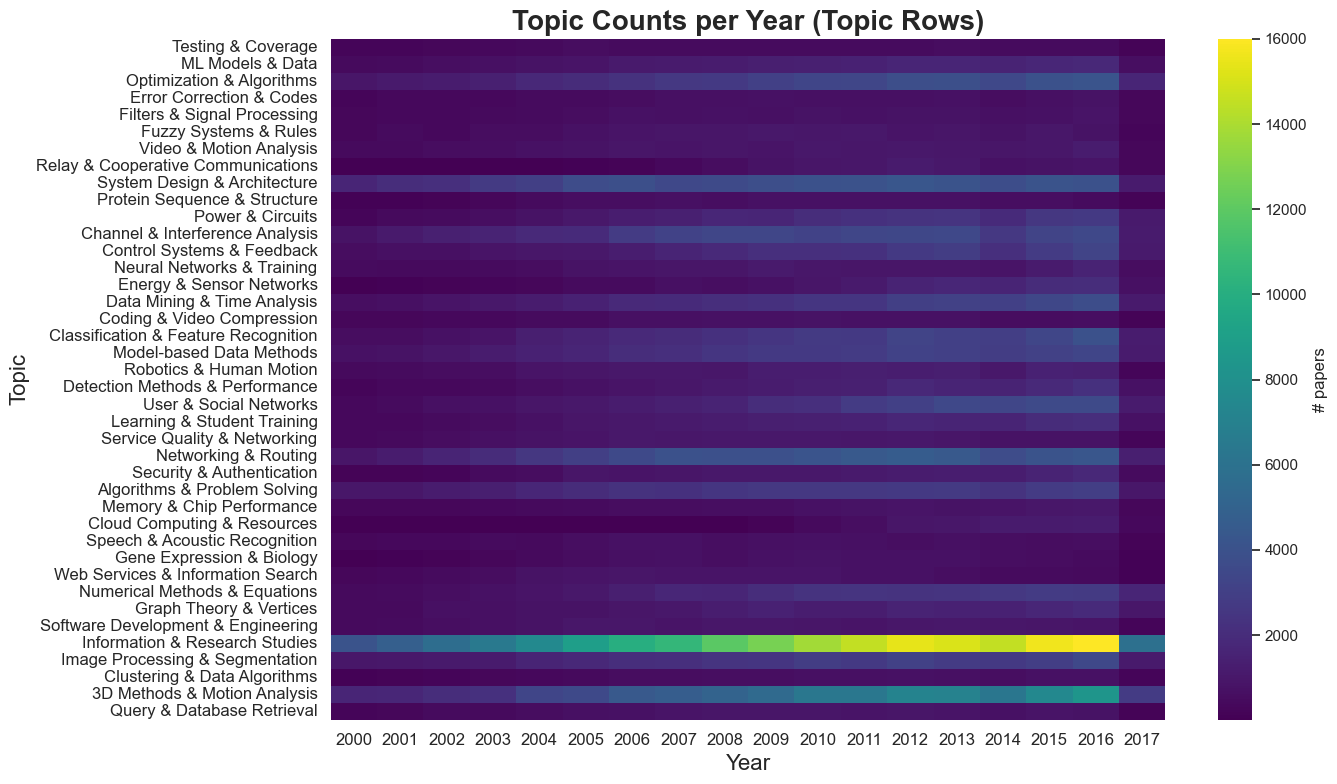

In [14]:
# topic counts and proportions per year
topic_year_counts = df_all.groupby(["year","topic"]).size().unstack(fill_value=0)
topic_year_prop = topic_year_counts.div(topic_year_counts.sum(axis=1).replace(0,1), axis=0)

# heatmap 
plt.figure(figsize=(14,8))
sns.heatmap(
    topic_year_counts.T,
    cmap="viridis",
    cbar_kws={"label": "# papers"}
)

plt.title("Topic Counts per Year (Topic Rows)", fontsize=20, fontweight="bold")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Topic", fontsize=16)

topic_labels_for_heatmap = [human_labels.get(t, f"T{t}") for t in topic_year_counts.columns]

plt.yticks(
    np.arange(len(topic_labels_for_heatmap)) + 0.5,
    topic_labels_for_heatmap,
    rotation=0,
    fontsize=12
)

plt.xticks(fontsize=12)

plt.tight_layout()
plt.show()

Line plot for topic prevalence over time

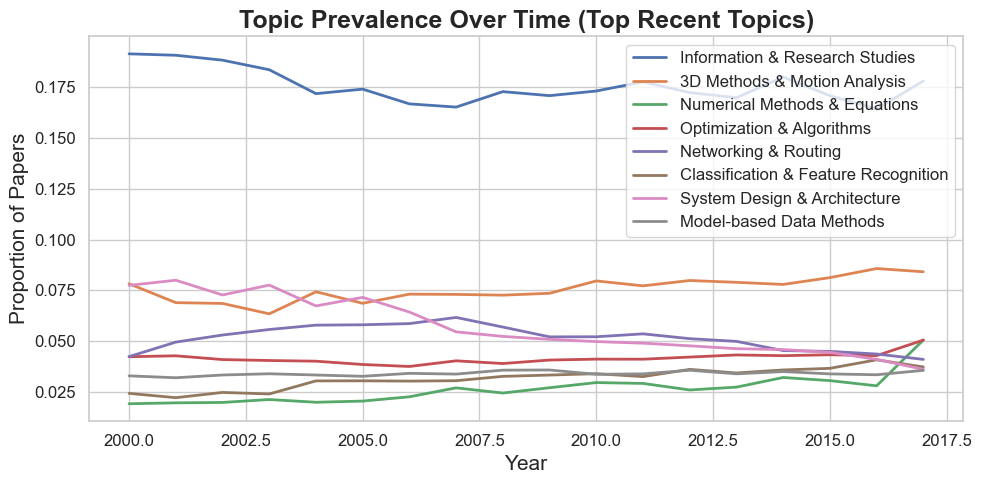

In [15]:
# line plot for top topics by recent prevalence 
recent_year = df_all["year"].max()
top_topics_recent = topic_year_counts.loc[recent_year].sort_values(ascending=False).index[:8]

plt.figure(figsize=(10,5))

for t in top_topics_recent:
    plt.plot(
        topic_year_prop.index,
        topic_year_prop[t],
        label=human_labels.get(t, f"T{t}"),
        linewidth=2
    )

plt.legend(fontsize=12)
plt.title("Topic Prevalence Over Time (Top Recent Topics)", fontsize=18, fontweight="bold")
plt.xlabel("Year", fontsize=15)
plt.ylabel("Proportion of Papers", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


Topic drift: centroid per topic per year & year-to-year shifts

In [16]:
# compute centroids for each (topic, year) in reduced SVD space X_all_text_reduced
topic_year_centroids = {}
for t in range(K):
    td = df_all[df_all["topic"]==t]
    if td.empty:
        continue
    for y, group in td.groupby("year"):
        inds = group.index.values
        topic_year_centroids.setdefault(t,{})[y] = X_all_text_reduced[inds].mean(axis=0)

# compute year-to-year cosine distance per topic
topic_drifts = {}
for t, yd in topic_year_centroids.items():
    yrs = sorted(yd.keys())
    drift_series = {}
    for i in range(1, len(yrs)):
        y_prev, y_cur = yrs[i-1], yrs[i]
        c_prev = yd[y_prev].reshape(1,-1)
        c_cur = yd[y_cur].reshape(1,-1)
        d = cosine_distances(c_cur, c_prev)[0,0]
        drift_series[y_cur] = d
    topic_drifts[t] = drift_series

# summarize drift per topic (mean and max)
drift_summary = []
for t, dmap in topic_drifts.items():
    if dmap:
        drift_summary.append({
            "topic": t,
            "drift_mean": np.mean(list(dmap.values())),
            "drift_max": np.max(list(dmap.values()))
        })
drift_summary_df = pd.DataFrame(drift_summary).sort_values("drift_max", ascending=False).reset_index(drop=True)
drift_summary_df.head(10)

,topic,drift_mean,drift_max
0,7,0.061130,0.431960
1,28,0.038963,0.176230
2,25,0.009278,0.036728
3,30,0.004535,0.022407
4,14,0.005011,0.018975
5,10,0.004345,0.018637
6,9,0.004997,0.015213
7,35,0.002704,0.013520
8,21,0.004692,0.012257
9,16,0.004883,0.011312


Fusion score (similarity to top 2 centroids) and fusion candidates

In [18]:
# compute distances / similarities for all papers in df_all reduced space
centers_all = km_all.cluster_centers_   # K x SVD_DIM
dists_all = cosine_distances(X_all_text_reduced, centers_all)  # n_all x K
nearest1 = np.argmin(dists_all, axis=1)
sorted_d = np.sort(dists_all, axis=1)
dist_to_1 = sorted_d[:,0]
dist_to_2 = sorted_d[:,1]
fusion_score_all = dist_to_2 - dist_to_1
df_all["nearest_topic_1"] = nearest1
df_all["dist_to_1"] = dist_to_1
df_all["dist_to_2"] = dist_to_2
df_all["fusion_score"] = fusion_score_all

fusion_threshold = df_all["fusion_score"].quantile(0.10)  # bottom 10% => fusion candidates
df_all["fusion_flag"] = (df_all["fusion_score"] <= fusion_threshold).astype(int)
print("Fusion candidates (all):", df_all["fusion_flag"].sum())


Fusion candidates (all): 111759


Fast-growing topics & chi-square tests

In [19]:
# compute recent growth per topic 
years_sorted = sorted(topic_year_counts.index)
recent_window = 3
if len(years_sorted) >= recent_window + 1:
    last_slice = topic_year_counts.loc[years_sorted[-(recent_window+1):]]
    pct = last_slice.pct_change().replace([np.inf,-np.inf], np.nan).fillna(0)
    topic_growth = pct.mean(axis=0)
else:
    topic_growth = topic_year_counts.mean(axis=0)

growth_cut = topic_growth.quantile(0.80)
fast_topics = topic_growth[topic_growth >= growth_cut].index.tolist()
print("Fast-growing topics:", fast_topics)

# bring anomaly flags into df_all for test years 
test_ids = set(test_df["id"].tolist())
df_all["is_test"] = df_all["id"].isin(test_ids).astype(int)
# merge anomaly flags from test_df into df_all
anomaly_map = dict(zip(test_df["id"], test_df["anomaly_flag"]))
df_all["is_anomaly"] = df_all["id"].map(anomaly_map).fillna(0).astype(int)

# chi-square: anomalies vs fusion (on test subset)
test_subset = df_all[df_all["is_test"]==1].copy()
cont_fusion = pd.crosstab(test_subset["is_anomaly"], test_subset["fusion_flag"])
chi2_f, p_f, _, _ = chi2_contingency(cont_fusion)
print("Anomalies vs Fusion contingency:\n", cont_fusion)
print(f"Chi2 p-value (anomalies vs fusion): {p_f:.4f}")

# chi-square: anomalies vs fast topic membership
test_subset["in_fast_topic"] = test_subset["topic"].isin(fast_topics).astype(int)
cont_fast = pd.crosstab(test_subset["is_anomaly"], test_subset["in_fast_topic"])
chi2_g, p_g, _, _ = chi2_contingency(cont_fast)
print("Anomalies vs FastTopic contingency:\n", cont_fast)
print(f"Chi2 p-value (anomalies vs fast topics): {p_g:.4f}")


Fast-growing topics: [3, 10, 12, 13, 17, 20, 32, 33]
Anomalies vs Fusion contingency:
 fusion_flag       0      1
is_anomaly                
0            187466  21281
1             12022   1239
Chi2 p-value (anomalies vs fusion): 0.0017
Anomalies vs FastTopic contingency:
 in_fast_topic       0      1
is_anomaly                  
0              168356  40391
1               10149   3112
Chi2 p-value (anomalies vs fast topics): 0.0000


In [20]:
from IPython.display import display, HTML

html = f"""
<div style="display: flex; gap: 50px;">
    <div>
        <h4>Anomalies vs Fusion</h4>
        {cont_fusion.to_html()}
        <p>Chi2 p-value: {p_f:.4f}</p>
    </div>
    <div>
        <h4>Anomalies vs Fast Topic</h4>
        {cont_fast.to_html()}
        <p>Chi2 p-value: {p_g:.4f}</p>
    </div>
</div>
"""

display(HTML(html))


fusion_flag,0,1
is_anomaly,,
0,187466,21281
1,12022,1239
in_fast_topic,0,1
is_anomaly,,
0,168356,40391
1,10149,3112


Plot of year-to-year centroid shifts for top-drift topics

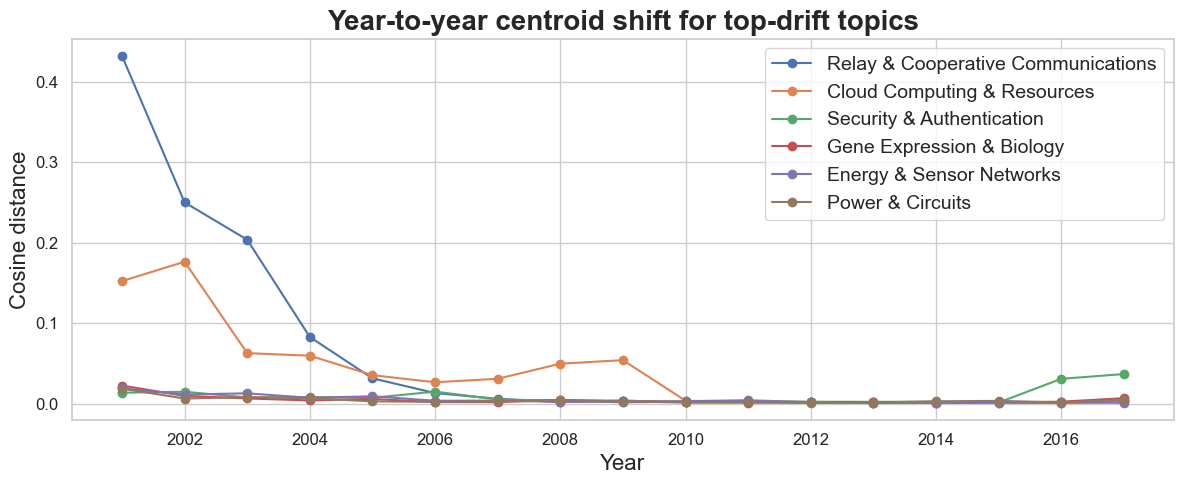

In [21]:
# topic drift lines for top-drift topics 
top_drift_topics = drift_summary_df.head(6)["topic"].tolist()

plt.figure(figsize=(12, 5))

for t in top_drift_topics:
    series = pd.Series(topic_drifts.get(t, {}))
    plt.plot(series.index, series.values, marker='o', label=human_labels.get(t, f"T{t}"))

plt.title("Year-to-year centroid shift for top-drift topics", fontsize=20, fontweight="bold")
plt.xlabel("Year", fontsize=16)
plt.ylabel("Cosine distance", fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


Fusion score histogram

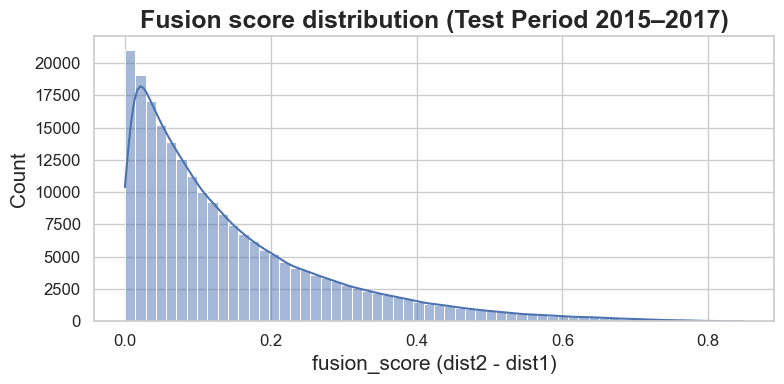

In [22]:
plt.figure(figsize=(8, 4))

sns.histplot(
    test_subset["fusion_score"].dropna(),
    bins=60,
    kde=True
)

plt.title("Fusion score distribution (Test Period 2015–2017)", fontsize=18, fontweight="bold")
plt.xlabel("fusion_score (dist2 - dist1)", fontsize=15)
plt.ylabel("Count", fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


Bar chart of anomaly rates per topic

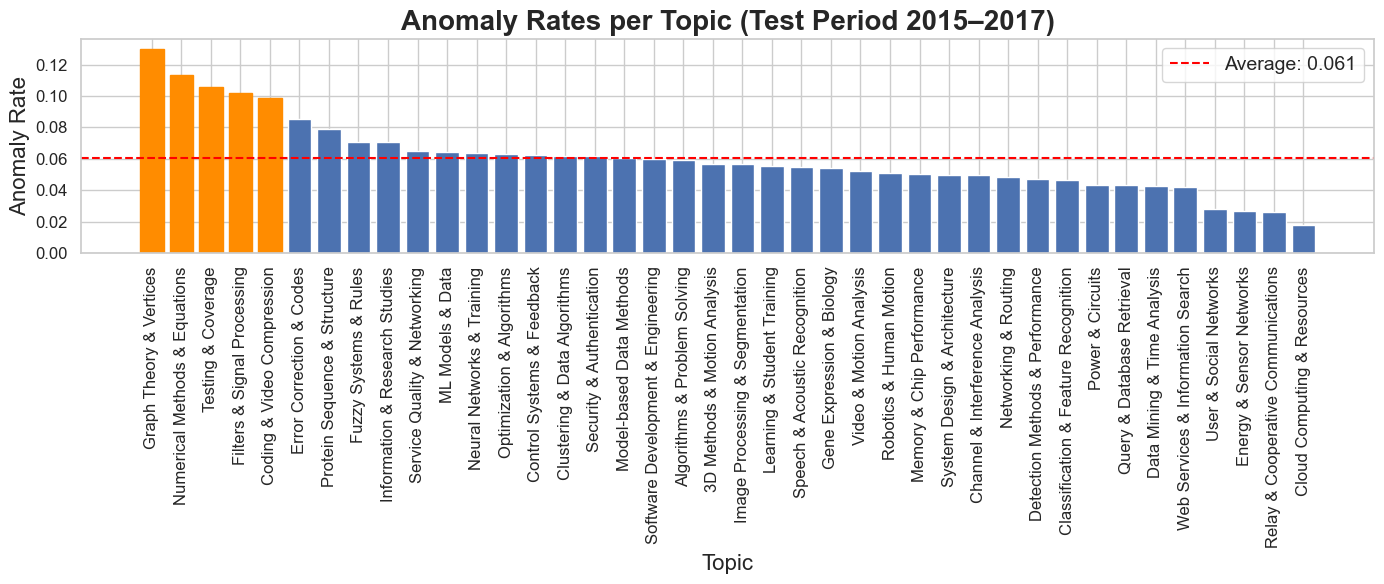

In [24]:
# anomaly rates per topic - bar chart
plt.figure(figsize=(14, 6))

# Get anomaly rates for all topics
anomaly_rates = []
topic_labels = []
for t in range(40):
    total = len(test_subset[test_subset["topic"] == t])
    anomalies = len(test_subset[(test_subset["topic"] == t) & (test_subset["is_anomaly"] == 1)])
    rate = anomalies / total if total > 0 else 0
    anomaly_rates.append(rate)
    topic_labels.append(human_labels.get(t, f"T{t}"))

# sort by anomaly rate
sorted_indices = np.argsort(anomaly_rates)[::-1]
sorted_rates = [anomaly_rates[i] for i in sorted_indices]
sorted_labels = [topic_labels[i] for i in sorted_indices]

bars = plt.bar(range(40), sorted_rates)

plt.axhline(
    y=np.mean(anomaly_rates),
    color='red',
    linestyle='--',
    label=f'Average: {np.mean(anomaly_rates):.3f}'
)

# highlight top 5
for i in range(5):
    bars[i].set_color('darkorange')

plt.title('Anomaly Rates per Topic (Test Period 2015–2017)', fontsize=20, fontweight='bold')
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Anomaly Rate', fontsize=16)
plt.xticks(range(40), sorted_labels, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


In [26]:
# calculate actual anomaly rates per topic
topic_stats = []
for t in range(40):
    total = len(df_all[df_all["topic"]==t])
    anomalies = len(df_all[(df_all["topic"]==t) & (df_all["is_anomaly"]==1)])
    rate = anomalies/total if total>0 else 0
    topic_stats.append({"topic": t, "anomaly_rate": rate, "total": total})

In [32]:
# anomaly counts per topic
topic_stats = []
for t in range(40):  # assuming 40 topics
    # Get total papers in this topic (in test period)
    total_in_topic = len(test_subset[test_subset["topic"] == t])
    
    # Get anomalies in this topic
    anomalies_in_topic = len(test_subset[(test_subset["topic"] == t) & (test_subset["is_anomaly"] == 1)])
    
    # Calculate rate
    rate = anomalies_in_topic / total_in_topic if total_in_topic > 0 else 0
    
    topic_stats.append({
        "topic": t,
        "topic_label": human_labels.get(t, f"Topic {t}"),
        "total_papers": total_in_topic,
        "anomaly_count": anomalies_in_topic,
        "anomaly_rate": rate
    })

# Convert to DataFrame and sort
topic_stats_df = pd.DataFrame(topic_stats).sort_values("anomaly_rate", ascending=False)

In [34]:
# TOPIC GROWTH RATES 
# calculate growth rate for each topic (2017 vs 2000)
growth_rates = []
for t in range(40):
    if 2000 in topic_year_counts.index and 2017 in topic_year_counts.index:
        count_2000 = topic_year_counts.loc[2000, t] if t in topic_year_counts.columns else 0
        count_2017 = topic_year_counts.loc[2017, t] if t in topic_year_counts.columns else 0
        if count_2000 > 0:
            growth = (count_2017 - count_2000) / count_2000
        else:
            growth = float('inf') if count_2017 > 0 else 0
        growth_rates.append({
            "topic": t,
            "label": human_labels.get(t, f"Topic {t}"),
            "growth_rate": growth,
            "count_2000": count_2000,
            "count_2017": count_2017
        })

growth_df = pd.DataFrame(growth_rates).sort_values("growth_rate", ascending=False)


Correlation between topic anomaly rate and topic growth rate

In [35]:
# correlation: anomaly rate vs growth rate
print("\n=== ANOMALY RATE VS GROWTH RATE CORRELATION ===")
# merge anomaly rates with growth rates
merged = pd.merge(
    topic_stats_df[["topic", "anomaly_rate"]],
    growth_df[["topic", "growth_rate"]],
    on="topic"
)
correlation = merged["anomaly_rate"].corr(merged["growth_rate"])
print(f"Correlation coefficient (anomaly rate vs growth rate): {correlation:.4f}")


=== ANOMALY RATE VS GROWTH RATE CORRELATION ===
Correlation coefficient (anomaly rate vs growth rate): -0.3236


Correlation between topic drift and anomaly rate

In [36]:
# drift-anomaly analysis
print("\n=== DRIFT-ANOMALY RELATIONSHIP ===")
# Merge anomaly rates with drift metrics
drift_anomaly = pd.merge(
    topic_stats_df[["topic", "anomaly_rate"]],
    drift_summary_df[["topic", "drift_max", "drift_mean"]],
    on="topic"
)
corr_max = drift_anomaly["anomaly_rate"].corr(drift_anomaly["drift_max"])
corr_mean = drift_anomaly["anomaly_rate"].corr(drift_anomaly["drift_mean"])
print(f"Correlation (anomaly rate vs max drift): {corr_max:.4f}")
print(f"Correlation (anomaly rate vs mean drift): {corr_mean:.4f}")


=== DRIFT-ANOMALY RELATIONSHIP ===
Correlation (anomaly rate vs max drift): -0.3385
Correlation (anomaly rate vs mean drift): -0.3629


Comprehensive topic analysis

In [38]:
print("=== COMPREHENSIVE TOPIC ANALYSIS ===")

topic_metrics = []
recent_counts = topic_year_counts.loc[2017].sort_values(ascending=False)
total_2017 = recent_counts.sum()
for t in range(40):
    # Basic info
    label = human_labels.get(t, f"Topic {t}")
    
    # Anomaly metrics 
    anomaly_row = topic_stats_df[topic_stats_df["topic"] == t]
    anomaly_rate = anomaly_row["anomaly_rate"].values[0] if not anomaly_row.empty else 0
    anomaly_count = anomaly_row["anomaly_count"].values[0] if not anomaly_row.empty else 0
    total_papers = anomaly_row["total_papers"].values[0] if not anomaly_row.empty else 0
    
    # Growth metrics
    growth_row = growth_df[growth_df["topic"] == t]
    growth_rate = growth_row["growth_rate"].values[0] if not growth_row.empty else 0
    count_2000 = growth_row["count_2000"].values[0] if not growth_row.empty else 0
    count_2017 = growth_row["count_2017"].values[0] if not growth_row.empty else 0
    
    # Drift metrics
    drift_row = drift_summary_df[drift_summary_df["topic"] == t]
    drift_max = drift_row["drift_max"].values[0] if not drift_row.empty else 0
    drift_mean = drift_row["drift_mean"].values[0] if not drift_row.empty else 0
    
    # Fusion metrics (calculate from test_subset)
    topic_fusion_scores = test_subset[test_subset["topic"] == t]["fusion_score"].dropna()
    fusion_mean = topic_fusion_scores.mean() if len(topic_fusion_scores) > 0 else 0
    fusion_median = topic_fusion_scores.median() if len(topic_fusion_scores) > 0 else 0
    
    # Prevalence in 2017
    prevalence_2017 = recent_counts.get(t, 0) / total_2017 if total_2017 > 0 else 0
    
    topic_metrics.append({
        "topic": t,
        "label": label,
        "anomaly_rate": anomaly_rate,
        "anomaly_count": anomaly_count,
        "total_papers": total_papers,
        "growth_rate": growth_rate,
        "count_2000": count_2000,
        "count_2017": count_2017,
        "drift_max": drift_max,
        "drift_mean": drift_mean,
        "fusion_mean": fusion_mean,
        "fusion_median": fusion_median,
        "prevalence_2017": prevalence_2017
    })

topic_metrics_df = pd.DataFrame(topic_metrics)

# analysis 1: HIGH DRIFT vs LOW DRIFT TOPICS 
print("\n" + "="*60)
print("ANALYSIS 1: TOPIC DRIFT vs ANOMALY RATES")
print("="*60)

# Top 10 highest drift topics
top_drift = topic_metrics_df.sort_values("drift_max", ascending=False).head(10)
print("\nTOP 10 HIGHEST DRIFT TOPICS (conceptual change):")
print("-" * 80)
for _, row in top_drift.iterrows():
    print(f"{row['label']:40} | Drift: {row['drift_max']:.4f} | Anomaly Rate: {row['anomaly_rate']:.3f} | Growth: {row['growth_rate']:.1f}x")

# Bottom 10 drift topics (most stable)
bottom_drift = topic_metrics_df.sort_values("drift_max").head(10)
print("\n\nTOP 10 LOWEST DRIFT TOPICS (most stable):")
print("-" * 80)
for _, row in bottom_drift.iterrows():
    print(f"{row['label']:40} | Drift: {row['drift_max']:.4f} | Anomaly Rate: {row['anomaly_rate']:.3f} | Growth: {row['growth_rate']:.1f}x")

# Compare averages
print(f"\nAVERAGES:")
print(f"High drift topics (top 10):")
print(f"  Mean anomaly rate: {top_drift['anomaly_rate'].mean():.4f}")
print(f"  Mean growth: {top_drift['growth_rate'].mean():.1f}x")
print(f"  Mean fusion: {top_drift['fusion_mean'].mean():.4f}")
print(f"\nLow drift topics (bottom 10):")
print(f"  Mean anomaly rate: {bottom_drift['anomaly_rate'].mean():.4f}")
print(f"  Mean growth: {bottom_drift['growth_rate'].mean():.1f}x")
print(f"  Mean fusion: {bottom_drift['fusion_mean'].mean():.4f}")

# analysis 2: FAST GROWTH vs SLOW GROWTH 
print("\n" + "="*60)
print("ANALYSIS 2: TOPIC GROWTH vs ANOMALY RATES")
print("="*60)

# Top 10 fastest growing 
finite_growth = topic_metrics_df[topic_metrics_df["growth_rate"] < 1000]  # Filter out infinite
top_growth = finite_growth.sort_values("growth_rate", ascending=False).head(10)
print("\nTOP 10 FASTEST GROWING TOPICS:")
print("-" * 80)
for _, row in top_growth.iterrows():
    print(f"{row['label']:40} | Growth: {row['growth_rate']:.1f}x | Anomaly Rate: {row['anomaly_rate']:.3f} | Drift: {row['drift_max']:.4f}")

# Top 10 slowest growing (or declining)
bottom_growth = finite_growth.sort_values("growth_rate").head(10)
print("\n\nTOP 10 SLOWEST GROWING TOPICS:")
print("-" * 80)
for _, row in bottom_growth.iterrows():
    print(f"{row['label']:40} | Growth: {row['growth_rate']:.1f}x | Anomaly Rate: {row['anomaly_rate']:.3f} | Drift: {row['drift_max']:.4f}")

# Compare averages
print(f"\nAVERAGES:")
print(f"Fast growth topics (top 10):")
print(f"  Mean anomaly rate: {top_growth['anomaly_rate'].mean():.4f}")
print(f"  Mean drift: {top_growth['drift_max'].mean():.4f}")
print(f"  Mean fusion: {top_growth['fusion_mean'].mean():.4f}")
print(f"\nSlow growth topics (bottom 10):")
print(f"  Mean anomaly rate: {bottom_growth['anomaly_rate'].mean():.4f}")
print(f"  Mean drift: {bottom_growth['drift_max'].mean():.4f}")
print(f"  Mean fusion: {bottom_growth['fusion_mean'].mean():.4f}")

# analysis 3: FUSION vs NON-FUSION 
print("\n" + "="*60)
print("ANALYSIS 3: INTERDISCIPLINARITY (FUSION) vs ANOMALY RATES")
print("="*60)

# Top 10 most interdisciplinary (highest fusion scores)
top_fusion = topic_metrics_df.sort_values("fusion_mean", ascending=False).head(10)
print("\nTOP 10 MOST INTERDISCIPLINARY TOPICS (highest fusion):")
print("-" * 80)
for _, row in top_fusion.iterrows():
    print(f"{row['label']:40} | Fusion: {row['fusion_mean']:.4f} | Anomaly Rate: {row['anomaly_rate']:.3f} | Growth: {row['growth_rate']:.1f}x")

# Top 10 least interdisciplinary (most topic-pure)
bottom_fusion = topic_metrics_df.sort_values("fusion_mean").head(10)
print("\n\nTOP 10 LEAST INTERDISCIPLINARY TOPICS (most topic-pure):")
print("-" * 80)
for _, row in bottom_fusion.iterrows():
    print(f"{row['label']:40} | Fusion: {row['fusion_mean']:.4f} | Anomaly Rate: {row['anomaly_rate']:.3f} | Growth: {row['growth_rate']:.1f}x")

# Compare averages
print(f"\nAVERAGES:")
print(f"High fusion topics (top 10):")
print(f"  Mean anomaly rate: {top_fusion['anomaly_rate'].mean():.4f}")
print(f"  Mean growth: {top_fusion['growth_rate'].mean():.1f}x")
print(f"  Mean drift: {top_fusion['drift_max'].mean():.4f}")
print(f"\nLow fusion topics (bottom 10):")
print(f"  Mean anomaly rate: {bottom_fusion['anomaly_rate'].mean():.4f}")
print(f"  Mean growth: {bottom_fusion['growth_rate'].mean():.1f}x")
print(f"  Mean drift: {bottom_fusion['drift_max'].mean():.4f}")

# analysis 4: TOP ANOMALY TOPICS DETAILED 
print("\n" + "="*60)
print("ANALYSIS 4: TOP 10 ANOMALY TOPICS - COMPLETE PROFILE")
print("="*60)

top_anomaly = topic_metrics_df.sort_values("anomaly_rate", ascending=False).head(10)
print("\nTOP 10 TOPICS BY ANOMALY RATE:")
print("-" * 100)
print(f"{'Topic':40} | {'Anomaly Rate':12} | {'Growth':8} | {'Drift Max':10} | {'Fusion':8} | {'Papers':8}")
print("-" * 100)
for _, row in top_anomaly.iterrows():
    print(f"{row['label']:40} | {row['anomaly_rate']:.4f}       | {row['growth_rate']:6.1f}x | {row['drift_max']:.6f} | {row['fusion_mean']:.4f}  | {row['total_papers']:6}")

# Calculate averages for top anomaly topics
print(f"\nCHARACTERISTICS OF TOP ANOMALY TOPICS (top 10):")
print(f"  Mean growth rate: {top_anomaly['growth_rate'].mean():.1f}x")
print(f"  Mean max drift: {top_anomaly['drift_max'].mean():.6f}")
print(f"  Mean fusion score: {top_anomaly['fusion_mean'].mean():.4f}")
print(f"  Mean prevalence (2017): {top_anomaly['prevalence_2017'].mean():.4f}")

# Compare with overall averages
overall_growth = topic_metrics_df['growth_rate'].mean()
overall_drift = topic_metrics_df['drift_max'].mean()
overall_fusion = topic_metrics_df['fusion_mean'].mean()

print(f"\nCOMPARED TO OVERALL AVERAGES:")
print(f"  Growth: {top_anomaly['growth_rate'].mean():.1f}x vs {overall_growth:.1f}x")
print(f"  Drift: {top_anomaly['drift_max'].mean():.6f} vs {overall_drift:.6f}")
print(f"  Fusion: {top_anomaly['fusion_mean'].mean():.4f} vs {overall_fusion:.4f}")

=== COMPREHENSIVE TOPIC ANALYSIS ===

ANALYSIS 1: TOPIC DRIFT vs ANOMALY RATES

TOP 10 HIGHEST DRIFT TOPICS (conceptual change):
--------------------------------------------------------------------------------
Relay & Cooperative Communications       | Drift: 0.4320 | Anomaly Rate: 0.026 | Growth: 268.0x
Cloud Computing & Resources              | Drift: 0.1762 | Anomaly Rate: 0.018 | Growth: 82.5x
Security & Authentication                | Drift: 0.0367 | Anomaly Rate: 0.062 | Growth: 2.3x
Gene Expression & Biology                | Drift: 0.0224 | Anomaly Rate: 0.054 | Growth: 2.9x
Energy & Sensor Networks                 | Drift: 0.0190 | Anomaly Rate: 0.027 | Growth: 10.8x
Power & Circuits                         | Drift: 0.0186 | Anomaly Rate: 0.043 | Growth: 4.3x
Protein Sequence & Structure             | Drift: 0.0152 | Anomaly Rate: 0.079 | Growth: 0.8x
Information & Research Studies           | Drift: 0.0135 | Anomaly Rate: 0.071 | Growth: 0.4x
User & Social Networks            

Top 5 anomaly topics table with anomaly rate, growth, drift max, fusion, and number of papers

In [39]:
# TOP 5 ANOMALY TOPICS TABLE 
top_anomaly = topic_metrics_df.sort_values("anomaly_rate", ascending=False).head(5)

table_data = top_anomaly[['label', 'anomaly_rate', 'growth_rate', 'drift_max', 'fusion_mean', 'total_papers']].copy()
table_data.columns = ['Topic', 'Anomaly Rate', 'Growth', 'Drift Max', 'Fusion', 'Papers']

# Format numeric columns
table_data['Anomaly Rate'] = table_data['Anomaly Rate'].map("{:.4f}".format)
table_data['Growth'] = table_data['Growth'].map("{:.1f}x".format)
table_data['Drift Max'] = table_data['Drift Max'].map("{:.6f}".format)
table_data['Fusion'] = table_data['Fusion'].map("{:.4f}".format)
table_data['Papers'] = table_data['Papers'].astype(int)

display(HTML(f"<h3>Top 5 Anomaly Topics - Complete Profile</h3>"))
display(HTML(table_data.to_html(index=False, border=1)))

# SUMMARY TABLE: Top 5 vs Overall Averages
summary_data = {
    'Metric': ['Mean Growth Rate', 'Mean Max Drift', 'Mean Fusion Score', 'Mean Prevalence (2017)'],
    'Top 5': [
        f"{top_anomaly['growth_rate'].mean():.1f}x",
        f"{top_anomaly['drift_max'].mean():.6f}",
        f"{top_anomaly['fusion_mean'].mean():.4f}",
        f"{top_anomaly['prevalence_2017'].mean():.4f}"
    ],
    'Overall Avg': [
        f"{topic_metrics_df['growth_rate'].mean():.1f}x",
        f"{topic_metrics_df['drift_max'].mean():.6f}",
        f"{topic_metrics_df['fusion_mean'].mean():.4f}",
        "-"
    ]
}

summary_table = pd.DataFrame(summary_data)
display(HTML(f"<h3>Characteristics of Top Anomaly Topics (Top 5) vs Overall Averages</h3>"))
display(HTML(summary_table.to_html(index=False, border=1)))



Topic,Anomaly Rate,Growth,Drift Max,Fusion,Papers
Graph Theory & Vertices,0.1301,1.2x,0.008100,0.3766,4581
Numerical Methods & Equations,0.1135,3.0x,0.008196,0.1864,7190
Testing & Coverage,0.1057,-0.3x,0.006479,0.2946,1116
Filters & Signal Processing,0.1021,0.0x,0.007341,0.2162,1842
Coding & Video Compression,0.0989,-0.4x,0.011312,0.1758,1335


Metric,Top 5,Overall Avg
Mean Growth Rate,0.7x,9.6x
Mean Max Drift,0.008286,0.023895
Mean Fusion Score,0.2499,0.2067
Mean Prevalence (2017),0.0196,-


# Case Study

Case study of three anomalous paper with abstracts and additional information about the paper

In [41]:
print("=" * 80)
print("CASE STUDIES: THREE TYPES OF ANOMALOUS PAPERS")
print("=" * 80)

# get the three papers
titles = [
    "Vertex-transitive CIS graphs",
    "Simulation-based Bayesian optimal ALT designs for model discrimination", 
    "Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation"
]

# Make sure test_anomalies exists
if 'test_anomalies' not in locals():
    test_anomalies = test_subset[test_subset["is_anomaly"] == 1].copy()
    if 'topic' in test_anomalies.columns:
        test_anomalies["topic_label"] = test_anomalies["topic"].map(human_labels)

for i, title in enumerate(titles, 1):
    # Find the paper - try exact match first
    paper_match = test_anomalies[test_anomalies["title"] == title]
    
    # If not found, try partial match
    if len(paper_match) == 0:
        paper_match = test_anomalies[test_anomalies["title"].str.contains(title[:30])]
    
    if len(paper_match) > 0:
        paper = paper_match.iloc[0]
        
        print(f"\n{'='*80}")
        print(f"CASE STUDY {i}")
        print(f"{'='*80}")
        
        # Basic info
        print(f" TITLE: {paper['title']}")
        print(f" YEAR: {paper['year']}")
        
        # Citations
        if 'n_citation' in paper:
            print(f" CITATIONS: {paper['n_citation']}")
        
        # Venue
        if 'venue' in paper:
            print(f"  VENUE: {paper['venue']}")
        
        # Abstract 
        if 'abstract' in paper and isinstance(paper['abstract'], str):
            print(f"\n ABSTRACT:")
            print(paper['abstract'])  # Full abstract, no truncation
        
        # Topic info
        print(f"\n TOPIC INFORMATION:")
        if 'topic_label' in paper:
            print(f"   Primary Topic: {paper['topic_label']} (Topic {paper['topic']})")
        else:
            print(f"   Primary Topic: Topic {paper['topic']}")
        
        # Get topic metrics if available
        if 'topic_metrics_df' in locals():
            topic_id = paper['topic']
            topic_stats = topic_metrics_df[topic_metrics_df['topic'] == topic_id]
            
            if len(topic_stats) > 0:
                stats = topic_stats.iloc[0]
                print(f"   Topic Anomaly Rate: {stats['anomaly_rate']:.3f}")
                print(f"   Topic Growth (2000-2017): {stats['growth_rate']:.1f}×")
                print(f"   Topic Max Drift: {stats['drift_max']:.6f}")
                print(f"   Topic Avg Fusion: {stats['fusion_mean']:.3f}")
        
        # Paper metrics
        print(f"\n PAPER METRICS:")
        print(f"   Paper Fusion Score: {paper['fusion_score']:.3f}")
        
        if 'dist_to_1' in paper:
            print(f"   Distance to Primary Topic: {paper['dist_to_1']:.4f}")
        if 'dist_to_2' in paper:
            print(f"   Distance to 2nd Closest Topic: {paper['dist_to_2']:.4f}")
        
        print(f"\n PATTERN:")
        if i == 1:
            print("   Stable-field masterpiece: High anomaly in stable, focused field")
        elif i == 2:
            print("   Declining field surprise: Impact despite field contraction")
        elif i == 3:
            print("   Extreme interdisciplinary: Perfect balance between domains")
        
        print("\n")
        
    else:
        print(f"\n Paper not found: {title}")
        print("   Make sure test_anomalies is defined and contains anomaly papers.")

CASE STUDIES: THREE TYPES OF ANOMALOUS PAPERS

CASE STUDY 1
 TITLE: Vertex-transitive CIS graphs
 YEAR: 2015
 CITATIONS: 50
  VENUE: European Journal of Combinatorics

 ABSTRACT:
A CIS graph is a graph in which every maximal stable set and every maximal clique intersect. A graph is well-covered if all its maximal stable sets are of the same size, co-well-covered if its complement is well-covered, and vertex-transitive if, for every pair of vertices, there exists an automorphism of the graph mapping one to the other. We show that a vertex-transitive graph is CIS if and only if it is well-covered, co-well-covered, and the product of its clique and stability numbers equals its order. A graph is irreducible if no two distinct vertices have the same neighborhood. We classify irreducible well-covered CIS graphs with clique number at most 3 and vertex-transitive CIS graphs of valency at most 7, which include an infinite family. We also exhibit an infinite family of vertex-transitive CIS graph